In [52]:
import torch
# Is CUDA available now?
print('CUDA available: {}'.format(torch.cuda.is_available()))

CUDA available: True


In [53]:
!conda env list

# conda environments:
#
base                     /home/chirathv97/anaconda3
yolo3dpy37            *  /home/chirathv97/anaconda3/envs/yolo3dpy37



In [54]:
pwd

'/home/chirathv97/FYP/visualDet3D'

In [55]:
!chmod 777 -R /home/chirathv97/FYP/visualDet3D

In [56]:
torch.version.cuda

'11.6'

In [57]:
import sys
# sys.path.append("../")
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cython
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
import torchvision
from numba import jit
from tqdm import tqdm

In [58]:
from visualDet3D.data.kitti.utils import write_result_to_file
from visualDet3D.utils.utils import LossLogger, cfg_from_file
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT, PIPELINE_DICT
from visualDet3D.networks.heads.anchors import Anchors
from visualDet3D.networks.lib.fast_utils.hill_climbing import post_opt
from visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.utils.utils import convertAlpha2Rot, convertRot2Alpha, draw_3D_box, compound_annotation
import visualDet3D.data.kitti.dataset
from visualDet3D.utils.timer import Timer

In [59]:
print('CUDA available: {}'.format(torch.cuda.is_available()))

cfg = cfg_from_file("config/config.py")
is_test_train = True

checkpoint_name = "Stereo3D_latest.pth"

CUDA available: True


In [60]:
# Read Conifg File
cfg.batch_size=1
split_to_test='validation'

# Define dataset_name
is_test_train = split_to_test == 'training'
if split_to_test == 'training':
    dataset_name = cfg.data.train_dataset
elif split_to_test == 'test':
    dataset_name = cfg.data.test_dataset
else:
    dataset_name = cfg.data.val_dataset

# Make dataset
dataset = DATASET_DICT[dataset_name](
        cfg, split_to_test
        )

# Split train/validation data
if split_to_test=='training':
    dataset_val = DATASET_DICT[cfg.data.val_dataset](
            cfg, 'validation'
            )
    dataset.transform = dataset_val.transform
    dataset.collate_fn = dataset_val.collate_fn

# Build a detector network
detector = DETECTOR_DICT[cfg.detector.name](cfg.detector)
detector = detector.cuda()

# Tensor load by GPU
weight_path = os.path.join(cfg.path.checkpoint_path, checkpoint_name)
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))
new_dict = state_dict.copy()
for key in state_dict:
    if 'focalLoss' in key:
        new_dict.pop(key)

# Load the pre-trained model
detector.load_state_dict(new_dict, strict=False)
detector.eval().cuda()

# Testing pipeline
test_func = PIPELINE_DICT[cfg.trainer.test_func]

# Load projector and backprojector
projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

In [61]:
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

In [62]:
index = 0
def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)

def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

@jit(cache=True, nopython=True)
def ToColorDepth(depth_image:np.ndarray)->np.ndarray: #[H, W] -> [H, W, 3] # Used to draw depth predictions
    H, W = depth_image.shape
    max_depth = float(np.max(depth_image))
    cmap = np.array([
        [0,0,0,114],[0,0,1,185],[1,0,0,114],[1,0,1,174], 
        [0,1,0,114],[0,1,1,185],[1,1,0,114],[1,1,1,0]
    ])
    _sum  = 0
    for i in range(8):
        _sum += cmap[i, 3]
    
    weights = np.zeros(8)
    cumsum = np.zeros(8)
    for i in range(7):
        weights[i] = _sum / cmap[i, 3]
        cumsum[i+1] = cumsum[i] + cmap[i, 3] / _sum
    
    image = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            val = depth_image[i, j] / max_depth
            for k in range(7):
                if val <= cumsum[k + 1]:
                    break
            w = 1.0- (val - cumsum[k]) * weights[k]
            r = int( (w * cmap[k, 0] + (1 - w) * cmap[k+1, 0]) * 255 )
            g = int( (w * cmap[k, 1] + (1 - w) * cmap[k+1, 1]) * 255 )
            b = int( (w * cmap[k, 2] + (1 - w) * cmap[k+1, 2]) * 255 )
            image[i, j] = np.array([r,g,b])
    return image

In [63]:
def compute_once(index, is_draw=True, is_test_train=True):
    name = "%06d" % index
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    original_height = data['original_shape'][0]
    collated_data = dataset.collate_fn([data])
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    if len(collated_data) > 6:
        left_images, right_images, _, _, labels, bbox_3d, _ = collated_data
    else:
        left_images, right_images, _, _, labels, bbox_3d = collated_data
    image = left_images

    with torch.no_grad():
        
        left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
                                          P2.cuda().float(),
                                          P3.cuda().float()])
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())

            
    
    rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
    if len(scores) > 0:
        rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
    if is_draw:
        plt.imshow(np.clip(rgb_image, 0, 255))

    return np.clip(rgb_image, 0, 255)

/home/chirathv97/FYP/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/chirathv97/FYP/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


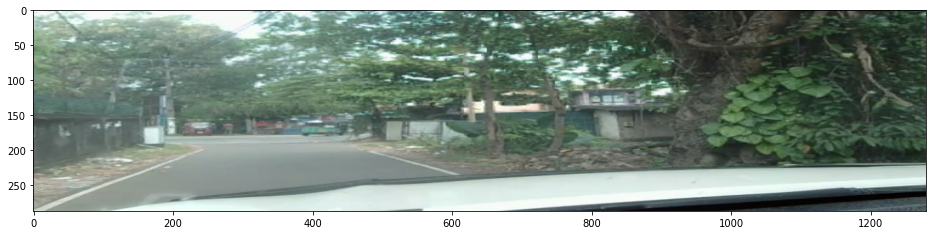

In [64]:
index = 900
fig = plt.figure(figsize=(16,9))
a = compute_once(index)

/home/chirathv97/FYP/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/chirathv97/FYP/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


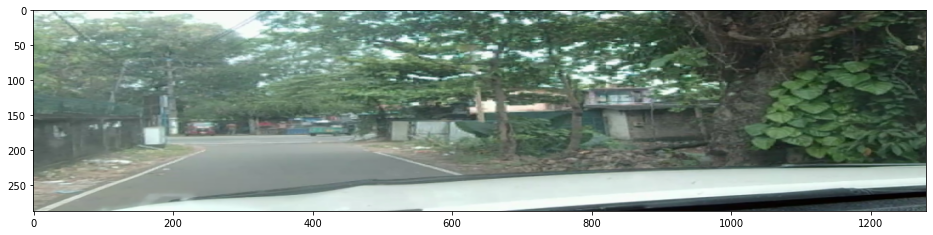

In [65]:
#%matplotlib inline
fig = plt.figure(figsize=(16,9))
index += 1
a = compute_once(index, is_test_train=False, is_draw=True)

In [ ]:
from IPython.display import clear_output

    
for index in range(1200,7481):
    fig = plt.figure(figsize=(16,9))
    a = compute_once(index, is_test_train=False, is_draw=True)
#     clear_output(wait=True)
    print(index,cv2.imwrite(('data/2d3d %03d.png'%index), cv2.cvtColor(a, cv2.COLOR_RGB2BGR)))
#     plt.xlabel(index)
#     plt.imshow(a)
#     plt.show()

/home/chirathv97/FYP/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/chirathv97/FYP/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


1200 True
1201 True
1202 True
1203 True
1204 True
1205 True
1206 True
1207 True
1208 True
1209 True
1210 True
1211 True
1212 True
1213 True
1214 True
1215 True
1216 True
1217 True
1218 True
1219 True


/home/chirathv97/anaconda3/envs/yolo3dpy37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


1220 True
1221 True
1222 True
1223 True
1224 True
1225 True
1226 True
1227 True
1228 True
1229 True
1230 True
1231 True
1232 True
1233 True
1234 True
1235 True
1236 True
1237 True
1238 True
1239 True
1240 True
1241 True
1242 True
1243 True
1244 True
1245 True
1246 True
1247 True
1248 True
1249 True
1250 True
1251 True
1252 True
1253 True
1254 True
1255 True
1256 True
1257 True
1258 True
1259 True
1260 True
1261 True
1262 True
1263 True
1264 True
1265 True
1266 True
1267 True
1268 True
1269 True
1270 True
1271 True
1272 True
1273 True
1274 True
1275 True
1276 True
1277 True
1278 True
1279 True
1280 True
1281 True
1282 True
1283 True
1284 True
1285 True
1286 True
1287 True
1288 True
1289 True
1290 True
1291 True
1292 True
1293 True
1294 True
1295 True
1296 True
1297 True
1298 True
1299 True
1300 True
1301 True
1302 True
1303 True
1304 True
1305 True
1306 True
1307 True
1308 True
1309 True
1310 True
1311 True
1312 True
1313 True
1314 True
1315 True
1316 True
1317 True
1318 True
1319 True


2040 True
2041 True
2042 True
2043 True
2044 True
2045 True
2046 True
2047 True
2048 True
2049 True
2050 True
2051 True
2052 True
2053 True
2054 True
2055 True
2056 True
2057 True
2058 True
2059 True
2060 True
2061 True
2062 True
2063 True
2064 True
2065 True
2066 True
2067 True
2068 True
2069 True
2070 True
2071 True
2072 True
2073 True
2074 True
2075 True
2076 True
2077 True
2078 True
2079 True
2080 True
2081 True
2082 True
2083 True
2084 True
2085 True
2086 True
2087 True
2088 True
2089 True
2090 True
2091 True
2092 True
2093 True
2094 True
2095 True
2096 True
2097 True
2098 True
2099 True
2100 True
2101 True
2102 True
2103 True
2104 True
2105 True
2106 True
2107 True
2108 True
2109 True
2110 True
2111 True
2112 True
2113 True
2114 True
2115 True
2116 True
2117 True
2118 True
2119 True
2120 True
2121 True
2122 True
2123 True
2124 True
2125 True
2126 True
2127 True
2128 True
2129 True
2130 True
2131 True
2132 True
2133 True
2134 True
2135 True
2136 True
2137 True
2138 True
2139 True


2861 True
2862 True
2863 True
2864 True
2865 True
2866 True
2867 True
2868 True
2869 True
2870 True
2871 True
2872 True
2873 True
2874 True
2875 True
2876 True
2877 True
2878 True
2879 True
2880 True
2881 True
2882 True
2883 True
2884 True
2885 True
2886 True
2887 True
2888 True
2889 True
2890 True
2891 True
2892 True
2893 True
2894 True
2895 True
2896 True
2897 True
2898 True
2899 True
2900 True
2901 True
2902 True
2903 True
2904 True
2905 True
2906 True
2907 True
2908 True
2909 True
2910 True
2911 True
2912 True
2913 True
2914 True
2915 True
2916 True
2917 True
2918 True
2919 True
2920 True
2921 True
2922 True
2923 True
2924 True
2925 True
2926 True
2927 True
2928 True
2929 True
2930 True
2931 True
2932 True
2933 True
2934 True
2935 True
2936 True
2937 True
2938 True
2939 True
2940 True
2941 True
2942 True
2943 True
2944 True
2945 True
2946 True
2947 True
2948 True
2949 True
2950 True
2951 True
2952 True
2953 True
2954 True
2955 True
2956 True
2957 True
2958 True
2959 True
2960 True


3681 True
3682 True
3683 True
3684 True
3685 True
3686 True
3687 True
3688 True
3689 True
3690 True
3691 True
3692 True
3693 True
3694 True
3695 True
3696 True
3697 True
3698 True
3699 True
3700 True
3701 True
3702 True
3703 True
3704 True
3705 True
3706 True
3707 True
3708 True
3709 True
3710 True
3711 True
3712 True
3713 True
3714 True
3715 True
3716 True
3717 True
3718 True
3719 True
3720 True
3721 True
3722 True
3723 True
3724 True
3725 True
3726 True
3727 True
3728 True
3729 True
3730 True
3731 True
3732 True
3733 True
3734 True
3735 True
3736 True
3737 True
3738 True
3739 True
3740 True
3741 True
3742 True
3743 True
3744 True
3745 True
3746 True
3747 True
3748 True
3749 True
3750 True
3751 True
3752 True
3753 True
3754 True
3755 True
3756 True
3757 True
3758 True
3759 True
3760 True
3761 True
3762 True
3763 True
3764 True
3765 True
3766 True
3767 True
3768 True
3769 True
3770 True
3771 True
3772 True
3773 True
3774 True
3775 True
3776 True
3777 True
3778 True
3779 True
3780 True


4501 True
4502 True
4503 True
4504 True
4505 True
4506 True
4507 True
4508 True
4509 True
4510 True
4511 True
4512 True
4513 True
4514 True
4515 True
4516 True
4517 True
4518 True
4519 True
4520 True
4521 True
4522 True
4523 True
4524 True
4525 True
4526 True
4527 True
4528 True
4529 True
4530 True
4531 True
4532 True
4533 True
4534 True
4535 True
4536 True
4537 True
4538 True
4539 True
4540 True
4541 True
4542 True
4543 True
4544 True
4545 True
4546 True
4547 True
4548 True
4549 True
4550 True
4551 True
4552 True
4553 True
4554 True
4555 True
4556 True
4557 True
4558 True
4559 True
4560 True
4561 True
4562 True
4563 True
4564 True
4565 True
4566 True
4567 True
4568 True
4569 True
4570 True
4571 True
4572 True
4573 True
4574 True
4575 True
4576 True
4577 True
4578 True
4579 True
4580 True
4581 True
4582 True
4583 True
4584 True
4585 True
4586 True
4587 True
4588 True
4589 True
4590 True
4591 True
4592 True
4593 True
4594 True
4595 True
4596 True
4597 True
4598 True
4599 True
4600 True


5322 True
5323 True
5324 True
5325 True
5326 True
5327 True
5328 True
5329 True
5330 True
5331 True
5332 True
5333 True
5334 True
5335 True
5336 True
5337 True
5338 True
5339 True
5340 True
5341 True
5342 True
5343 True
5344 True
5345 True
5346 True
5347 True
5348 True
5349 True
5350 True
5351 True
5352 True
5353 True
5354 True
5355 True
5356 True
5357 True
5358 True
5359 True
5360 True
5361 True
5362 True
5363 True
5364 True
5365 True
5366 True
5367 True
5368 True
5369 True
5370 True
5371 True
5372 True
5373 True
5374 True
5375 True
5376 True
5377 True
5378 True
5379 True
5380 True
5381 True
5382 True
5383 True
5384 True
5385 True
5386 True
5387 True
5388 True
5389 True
5390 True
5391 True
5392 True
5393 True
5394 True
5395 True
5396 True
5397 True
5398 True
5399 True
5400 True
5401 True
5402 True
5403 True
5404 True
5405 True
5406 True
5407 True
5408 True
5409 True
5410 True
5411 True
5412 True
5413 True
5414 True
5415 True
5416 True
5417 True
5418 True
5419 True
5420 True
5421 True


6143 True
6144 True
6145 True
6146 True
6147 True
6148 True
6149 True
6150 True
6151 True
6152 True
6153 True
6154 True
6155 True
6156 True
6157 True
6158 True
6159 True
6160 True
6161 True
6162 True
6163 True
6164 True
6165 True
6166 True
6167 True
6168 True
6169 True
6170 True
6171 True
6172 True
6173 True
6174 True
6175 True
6176 True
6177 True
6178 True
6179 True
6180 True
6181 True
6182 True
6183 True
6184 True
6185 True
6186 True
6187 True
6188 True
6189 True
6190 True
6191 True
6192 True
6193 True
6194 True
6195 True
6196 True
6197 True
6198 True
6199 True
6200 True
6201 True
6202 True
6203 True
6204 True
6205 True
6206 True
6207 True
6208 True
6209 True
6210 True
6211 True
6212 True
6213 True
6214 True
6215 True
6216 True
6217 True
6218 True
6219 True
6220 True
6221 True
6222 True
6223 True
6224 True
6225 True
6226 True
6227 True
6228 True
6229 True
6230 True
6231 True
6232 True
6233 True
6234 True
6235 True
6236 True
6237 True
6238 True
6239 True
6240 True
6241 True
6242 True


6963 True
6964 True
6965 True
6966 True
6967 True
6968 True
6969 True
6970 True
6971 True
6972 True
6973 True
6974 True
6975 True
6976 True
6977 True
6978 True
6979 True
6980 True
6981 True
6982 True
6983 True
6984 True
6985 True
6986 True
6987 True
6988 True
6989 True
6990 True
6991 True
6992 True
6993 True
6994 True
6995 True
6996 True
6997 True
6998 True
6999 True
7000 True
7001 True
7002 True
7003 True
7004 True
7005 True
7006 True
7007 True
7008 True
7009 True
7010 True
7011 True
7012 True
7013 True
7014 True
7015 True
7016 True
7017 True
7018 True
7019 True
7020 True
7021 True
7022 True
7023 True
7024 True
7025 True
7026 True
7027 True
7028 True
7029 True
7030 True
7031 True
7032 True
7033 True
7034 True
7035 True
7036 True
7037 True
7038 True
7039 True
7040 True
7041 True
7042 True
7043 True
7044 True
7045 True
7046 True
7047 True
7048 True
7049 True
7050 True
7051 True
7052 True
7053 True
7054 True
7055 True
7056 True
7057 True
7058 True
7059 True
7060 True
7061 True
7062 True
